Presentation:
## Dual Contouring

https://www.meetup.com/Papers-We-Love-Montreal/events/244906577

0. Intro

Do a little poll to get the audiences interest and level.

1. problem statement and definitions

consider a function implicitly defined on a lattice
Generation of an iso surface.

Why would you do this?
Some data just naturally is this way (ct,mr)
representation of an object as a distance field
certain types of editing are easy

important notions
implicit surface and explicit surface
distance field
level set
structured grid vs unstructured grid implicit grid vs explicit mesh
manifold mesh

cubes<->hexahedrons
Voxels as point samples - the value is at the voxel point.  (The alternative is voxels are a cube filled to a level)  It doesn't matter until it does.

Duality

k-complex.  Vertex, edge, cell, face

2. Marching cubes

Consider the cells of our grid.  For each cell, look at the corners.

Maybe all the corners are on the same side of the surface.  Woo, easy, there is no surface in it.  I know how to do that!

Ok, what if some corners are in and some are out.  Then we can define a surface in there

There are 8 corners, each of which could be either in or out, leading to 256 combinations, naturally indexed.

Which leads, in turn, to what is rumored to be the most cut and pasted code on the entire internet!

Where exactly do we put the triangle vertices - on the edges, at an interpolated point.  The interpolation is the same on both sides, so it matches.


You can march other tesselations of space (tetrahedra, octahedra, unstructured grids and mixed grids). We'll stick to cubes and squares today

Interesting historical note, MC was patented, leading to much frustration of course, and marching tetrahedra at least was definitely a response to that.  Any cube can be subivided into tetrahedra.

Are we done yet?

So for each cube, we get zero or more triangles, and the set of all these triangles will be the surface.  

Mmmm triangle soup.  We actually want a mesh in the sense of vertices and faces.  That requires some accounting work. (probably out of scope for the talk)

(Oh oops, theres an ambiguous case.  wave hands and sweep it under carpet)


3. Limitations
- representation of small features and detail
- binary feature jaggies (this is the surfacenets motivation)

- too many surface elements.

Deal with detail first - 
4. What if we know more information
- hermite data
WTF is hermite data?
Hermite interpolation (Charles Hermite)
https://en.wikipedia.org/wiki/Charles_Hermite
man that guy looks grumpy

5. What about these triangles?


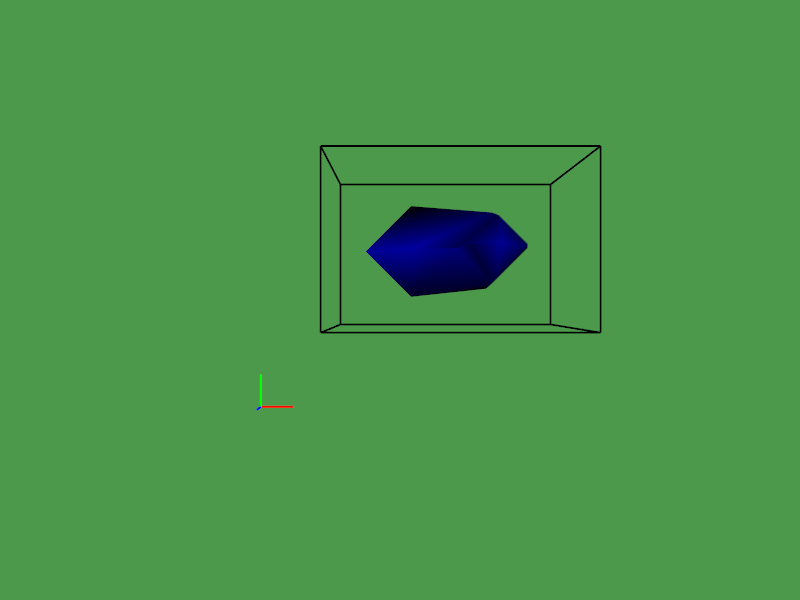

In [71]:
import vtk
from vtk.util.vtkConstants import *


from IPython.display import Image

Red=(1,0,0)
Blue=(0,0,1)
Green=(0,1,0)
Yellow=(1,1,0)
Magenta=(1,0,1)
Cyan=(0,1,1)
Purple=(0.5,0,0.5)
Orange=(1,0.5,0)
Brown=(0.6,0.5,0.1)
Black=(0,0,0)
White=(1,1,1)
Gray=(0.5,0.5,0.5)

def vtk_show(renderer, width=400, height=300):
    """
    Takes vtkRenderer instance and returns an IPython Image with the rendering.
    """
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(width, height)
    renderWindow.Render()
     
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()
     
    writer = vtk.vtkPNGWriter()
    writer.SetWriteToMemory(1)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    data = str(buffer(writer.GetResult()))
    
    return Image(data)

def SetColor(actor,c):
   actor.GetProperty().SetColor(c[0],c[1],c[2])
def SetLineWidth(actor,w):
   actor.GetProperty().SetLineWidth(w)


def MarchingCubes(img_data):
    importer = vtk.vtkImageImport()
    img_string = img_data.tostring(order='F')
    dim = img_data.shape
        
    importer.CopyImportVoidPointer(img_string, len(img_string))
    importer.SetDataScalarType(VTK_UNSIGNED_CHAR)
    importer.SetNumberOfScalarComponents(1)
        
    extent = importer.GetDataExtent()
    importer.SetDataExtent(extent[0], extent[0] + dim[0] - 1,
                       extent[2], extent[2] + dim[1] - 1,
                       extent[4], extent[4] + dim[2] - 1)
    importer.SetWholeExtent(extent[0], extent[0] + dim[0] - 1,
                        extent[2], extent[2] + dim[1] - 1,
                        extent[4], extent[4] + dim[2] - 1)
    #importer.SetDataSpacing( dset.pixel_spacing[0], dset.pixel_spacing[1], dset.pixel_spacing[2])
    
    outlineData=vtk.vtkOutlineFilter()
    outlineData.SetInputConnection(importer.GetOutputPort())
    
    mapOutline=vtk.vtkPolyDataMapper()
    mapOutline.SetInputConnection(outlineData.GetOutputPort())
    outline=vtk.vtkActor()
    outline.SetMapper(mapOutline)
    
    skinExtractor=vtk.vtkContourFilter()
    skinExtractor.SetInputConnection(importer.GetOutputPort())
    skinExtractor.SetValue(0,100)
    skinExtractor.Update()
    
    tri=vtk.vtkTriangleFilter()
    tri.SetInputConnection(skinExtractor.GetOutputPort())
    tri.Update()
    
#    deci=vtk.vtkQuadricDecimation()
#    deci.SetInputConnection(tri.GetOutputPort())
#    deci.SetTargetReduction(0.95)
#    # deci-$obj PreserveTopologyOn
#    deci.Update()
    
    skinNormals=vtk.vtkPolyDataNormals()
    #  skinNormals SetInputConnection [skinExtractor GetOutputPort]
    skinNormals.SetInputConnection(tri.GetOutputPort())
    skinNormals.SetFeatureAngle( 60.0)
    
    skinMapper=vtk.vtkPolyDataMapper()
    skinMapper.SetInputConnection(skinNormals.GetOutputPort())
        #  skinMapper SetInputConnection [deci GetOutputPort]
    #skinMapper.ScalarVisibilityOff()
       
    skin=vtk.vtkActor()
    skin.SetMapper(skinMapper)
    return outline,skin
img_data=np.zeros((4,3,5),dtype=np.uint8,order='C')
#img_data[5:10,5:10,5:10]=255
img_data[1,1,1]=255
img_data[2,1,1]=200
img_data[2,1,2]=180
img_data[2,1,3]=150


outline,data=MarchingCubes(img_data)
SetColor(outline,Black)
SetLineWidth(outline,2)
SetColor(data,Magenta)

def MakeAxes(point,length):
    xpts=vtk.vtkPoints()
    xlines=vtk.vtkCellArray()
    xpts.InsertNextPoint(point)
    xpts.InsertNextPoint((point[0]+length,point[1],point[2]))
    xlines.InsertNextCell(2)
    xlines.InsertCellPoint(0)
    xlines.InsertCellPoint(1)
    xpoly=vtk.vtkPolyData()
    xpoly.SetPoints(xpts)
    xpoly.SetLines(xlines)

    xpolyMapper=vtk.vtkPolyDataMapper()
    xpolyMapper.SetInputData(xpoly)
       
    xpolyActor=vtk.vtkActor()
    xpolyActor.SetMapper(xpolyMapper)

    SetColor(xpolyActor,Red)
    SetLineWidth(xpolyActor,2)

    ypts=vtk.vtkPoints()
    ylines=vtk.vtkCellArray()
    ypts.InsertNextPoint(point)
    ypts.InsertNextPoint((point[0],point[1]+length,point[2]))
    ylines.InsertNextCell(2)
    ylines.InsertCellPoint(0)
    ylines.InsertCellPoint(1)
    ypoly=vtk.vtkPolyData()
    ypoly.SetPoints(ypts)
    ypoly.SetLines(ylines)

    ypolyMapper=vtk.vtkPolyDataMapper()
    ypolyMapper.SetInputData(ypoly)
       
    ypolyActor=vtk.vtkActor()
    ypolyActor.SetMapper(ypolyMapper)

    SetColor(ypolyActor,Green)
    SetLineWidth(ypolyActor,2)

    zpts=vtk.vtkPoints()
    zlines=vtk.vtkCellArray()
    zpts.InsertNextPoint(point)
    zpts.InsertNextPoint((point[0],point[1],point[2]+length))
    zlines.InsertNextCell(2)
    zlines.InsertCellPoint(0)
    zlines.InsertCellPoint(1)
    zpoly=vtk.vtkPolyData()
    zpoly.SetPoints(zpts)
    zpoly.SetLines(zlines)

    zpolyMapper=vtk.vtkPolyDataMapper()
    zpolyMapper.SetInputData(zpoly)
       
    zpolyActor=vtk.vtkActor()
    zpolyActor.SetMapper(zpolyMapper)

    SetColor(zpolyActor,Blue)
    SetLineWidth(zpolyActor,2)
    return xpolyActor,ypolyActor,zpolyActor

xa,ya,za=MakeAxes((-1.3,-1.3,-1.3),0.5)

# skin.SetUserMatrix(M)
renderer=vtk.vtkRenderer()
renderer.AddActor(data)
renderer.AddActor(outline)
renderer.AddActor(xa)
renderer.AddActor(ya)
renderer.AddActor(za)
renderer.SetBackground(.3, .6, .3)
 
renderWindow=vtk.vtkRenderWindow()
renderWindow.AddRenderer(renderer)
renderWindow.SetStereoTypeToRedBlue() #Anaglyphic FTW
 
renderWindowInteractor=vtk.vtkRenderWindowInteractor()
renderWindowInteractor.SetRenderWindow(renderWindow)
 
renderWindowInteractor.Start()

renderWindow.Finalize()
renderWindowInteractor.TerminateApp()
del renderWindow,renderWindowInteractor

# this has to be the last thing
vtk_show(renderer,800,600)

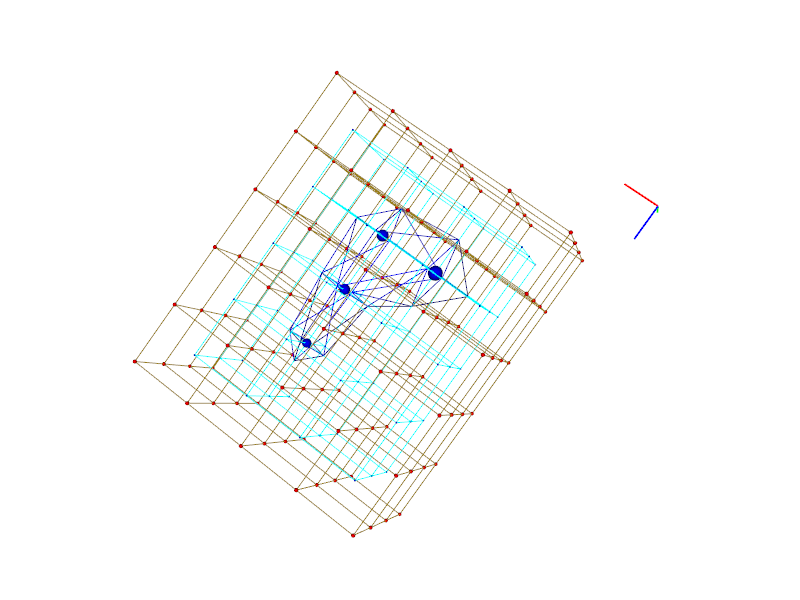

In [86]:
pts=vtk.vtkPoints()
lines=vtk.vtkCellArray()
sz=img_data.shape
for i in range(sz[0]):
    for j in range(sz[1]):
        for k in range(sz[2]):
            pts.InsertNextPoint((i,j,k))
for i in range(sz[0]):
    for j in range(sz[1]):
        for k in range(sz[2]):
            if i<sz[0]-1:
                lines.InsertNextCell(2)
                lines.InsertCellPoint(i*(sz[2])*(sz[1])+j*(sz[2])+k)
                lines.InsertCellPoint((i+1)*(sz[2])*(sz[1])+j*(sz[2])+k)
            if j<sz[1]-1:
                lines.InsertNextCell(2)
                lines.InsertCellPoint(i*(sz[2])*(sz[1])+j*(sz[2])+k)
                lines.InsertCellPoint(i*(sz[2])*(sz[1])+(j+1)*(sz[2])+k)
            if k<sz[2]-1:
                lines.InsertNextCell(2)
                lines.InsertCellPoint(i*(sz[2])*(sz[1])+j*(sz[2])+k)
                lines.InsertCellPoint(i*(sz[2])*(sz[1])+j*(sz[2])+k+1)
            
primal=vtk.vtkPolyData()
primal.SetPoints(pts)
primal.SetLines(lines)

scalars=vtk.vtkDoubleArray()
scalars.SetNumberOfValues(sz[0]*sz[1]*sz[2])
c=0
for i in range(sz[0]):
    for j in range(sz[1]):
        for k in range(sz[2]):
            scalars.SetValue(c,(img_data[i,j,k]/255.)*0.2+0.03)
            c=c+1


primal.GetPointData().SetScalars(scalars)

primalMapper=vtk.vtkPolyDataMapper()
primalMapper.SetInputData(primal)
primalMapper.ScalarVisibilityOff()
        #  skinMapper SetInputConnection [deci GetOutputPort]
    #skinMapper.ScalarVisibilityOff()
       
primalActor=vtk.vtkActor()
primalActor.SetMapper(primalMapper)

SetColor(primalActor,Cyan)


primalglyph=vtk.vtkSphereSource()
primalglyph.SetRadius(0.5)
primalglyph.SetThetaResolution(12)
primalglyph.SetPhiResolution(12)

primalPoints=vtk.vtkGlyph3D()
primalPoints.SetInputData(primal)
primalPoints.SetSourceConnection(primalglyph.GetOutputPort())

primalPointMapper=vtk.vtkPolyDataMapper()
primalPointMapper.SetInputConnection(primalPoints.GetOutputPort())
primalPointMapper.ScalarVisibilityOff()

primalPointActor=vtk.vtkActor()
primalPointActor.SetMapper(primalPointMapper)
SetColor(primalPointActor,Blue)




pts=vtk.vtkPoints()
lines=vtk.vtkCellArray()
sz=img_data.shape
for i in range(sz[0]+1):
    for j in range(sz[1]+1):
        for k in range(sz[2]+1):
            pts.InsertNextPoint((i-0.5,j-0.5,k-0.5))
for i in range(sz[0]+1):
    for j in range(sz[1]+1):
        for k in range(sz[2]+1):
            if i<sz[0]:
                lines.InsertNextCell(2)
                lines.InsertCellPoint(i*(sz[2]+1)*(sz[1]+1)+j*(sz[2]+1)+k)
                lines.InsertCellPoint((i+1)*(sz[2]+1)*(sz[1]+1)+j*(sz[2]+1)+k)
            if j<sz[1]:
                lines.InsertNextCell(2)
                lines.InsertCellPoint(i*(sz[2]+1)*(sz[1]+1)+j*(sz[2]+1)+k)
                lines.InsertCellPoint(i*(sz[2]+1)*(sz[1]+1)+(j+1)*(sz[2]+1)+k)
            if k<sz[2]:
                lines.InsertNextCell(2)
                lines.InsertCellPoint(i*(sz[2]+1)*(sz[1]+1)+j*(sz[2]+1)+k)
                lines.InsertCellPoint(i*(sz[2]+1)*(sz[1]+1)+j*(sz[2]+1)+k+1)
            
dual=vtk.vtkPolyData()
dual.SetPoints(pts)
dual.SetLines(lines)

dualMapper=vtk.vtkPolyDataMapper()
dualMapper.SetInputData(dual)
        #  skinMapper SetInputConnection [deci GetOutputPort]
    #skinMapper.ScalarVisibilityOff()
       
dualActor=vtk.vtkActor()
dualActor.SetMapper(dualMapper)

SetColor(dualActor,Brown)


dualglyph=vtk.vtkSphereSource()
dualglyph.SetRadius(0.03)
dualglyph.SetThetaResolution(12)
dualglyph.SetPhiResolution(12)

dualPoints=vtk.vtkGlyph3D()
dualPoints.SetInputData(dual)
dualPoints.SetSourceConnection(dualglyph.GetOutputPort())

dualPointMapper=vtk.vtkPolyDataMapper()
dualPointMapper.SetInputConnection(dualPoints.GetOutputPort())

dualPointActor=vtk.vtkActor()
dualPointActor.SetMapper(dualPointMapper)
SetColor(dualPointActor,Red)


renderer=vtk.vtkRenderer()
renderer.AddActor(data)
#renderer.AddActor(outline)
renderer.AddActor(primalActor)
renderer.AddActor(primalPointActor)
renderer.AddActor(dualActor)
renderer.AddActor(dualPointActor)
renderer.AddActor(xa)
renderer.AddActor(ya)
renderer.AddActor(za)

#renderer.SetBackground(.3, .6, .3)
renderer.SetBackground(1, 1, 1)
 
renderWindow=vtk.vtkRenderWindow()
renderWindow.AddRenderer(renderer)
renderWindow.SetStereoTypeToRedBlue() #Anaglyphic FTW
 
renderWindowInteractor=vtk.vtkRenderWindowInteractor()
renderWindowInteractor.SetRenderWindow(renderWindow)
 
renderWindowInteractor.Start()

renderWindow.Finalize()
renderWindowInteractor.TerminateApp()
del renderWindow,renderWindowInteractor

# this has to be the last thing
vtk_show(renderer,800,600)



In [ ]:
# Initial code setup
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import pandas as pd
#%matplotlib inline
fig_size_inline = (12, 9)
#plt.rcParams["figure.figsize"] = fig_size
%matplotlib notebook
fig_size_notebook = (9, 7)
plt.rcParams["figure.figsize"] = fig_size_notebook




# -*- coding: utf-8 -*-
"""
vtk simple read and display
of data saved from SimOrtho
"""
import vtk
import SimpleITK as sitk
import numpy as np
import itertools
from vtk.util.vtkConstants import *
import glob


pth="D:/UE4a/Engine/Binaries/Win64/"
pth="Y:/Collaborations/ETS/ExportForETS/00_InitialScene/"
pth="C:/Work/b2/SimOrtho/Saved/SceneObjects/"
objs=glob.glob("data2/*.obj")
vxls=glob.glob("data2/*_voxels.mhd")
objs=glob.glob(pth+"*.obj")
vxls=glob.glob(pth+"*_voxels.mhd")

cols=[[1,0,0],[0,1,0],]#[0,0,1],[0,1,1],[1,0,1]]

# A texture is loaded using an image reader. Textures are simply images.
# The texture is eventually associated with an actor.
imgReader = vtk.vtkJPEGReader()
imgReader.SetFileName("data/checkerboardfine.jpg")
atext = vtk.vtkTexture()
atext.SetInputConnection(imgReader.GetOutputPort())
atext.InterpolateOn()


def readIMG(fm,col,flip=False):
    img = sitk.ReadImage( fm ) # SimpleITK object
    data = sitk.GetArrayFromImage( img ) # numpy array
    spacing=img.GetSpacing()
    origin=img.GetOrigin()
    # Convert from LPS to RAS
    # Slicer3D insists on having volumes in LPS, and meshes in RAS
    # We adhere to this convention, but this means that we save data
    # from the same scene in two different coordinate systems
    print("Volume Size in units")
    print([a*b for a,b in zip(data.shape,spacing)])
    origin=(-origin[0],-origin[1],origin[2])
    D=img.GetDirection()
    Dmtx=np.array(D).reshape((3,3)).T
    print "Direction det",np.linalg.det(Dmtx)
    LPSToRAS=np.eye(3)*-1.
    LPSToRAS[2,2]=1.
    Dconverted=np.dot(Dmtx,LPSToRAS)
    
    M=vtk.vtkMatrix4x4()
    M.Identity()
    for i in range(3):
       M.SetElement(i,3,origin[i])
       for j in range(3):
          M.SetElement(i,j,Dconverted[j,i])
    
    importer = vtk.vtkImageImport()
      
    img_data = data.astype('uint8')
    img_string = img_data.tostring() # type short
    dim = data.shape
        
    importer.CopyImportVoidPointer(img_string, len(img_string))
    importer.SetDataScalarType(VTK_UNSIGNED_CHAR)
    importer.SetNumberOfScalarComponents(1)
        
    extent = importer.GetDataExtent()
    importer.SetDataExtent(extent[0], extent[0] + dim[2] - 1,
                           extent[2], extent[2] + dim[1] - 1,
                           extent[4], extent[4] + dim[0] - 1)
    importer.SetWholeExtent(extent[0], extent[0] + dim[2] - 1,
                            extent[2], extent[2] + dim[1] - 1,
                            extent[4], extent[4] + dim[0] - 1)
    importer.SetDataSpacing( spacing[0], spacing[1], spacing[2])
    
    
    outlineData=vtk.vtkOutlineFilter()
    outlineData.SetInputConnection(importer.GetOutputPort())
    
    mapOutline=vtk.vtkPolyDataMapper()
    mapOutline.SetInputConnection(outlineData.GetOutputPort())
    outline=vtk.vtkActor()
    outline.SetMapper(mapOutline)
    outline.GetProperty().SetColor(0,0,1)
    #outline-$obj GetProperty] SetLineWidth $linewidth
    if flip:
       M2=vtk.vtkMatrix4x4()
       M2.Identity()
       M2.SetElement(0,0,-1)
       M2.SetElement(1,1,0)
       M2.SetElement(2,2,0)
       M2.SetElement(2,1,1)
       M2.SetElement(1,2,1)
       N=vtk.vtkMatrix4x4()
       vtk.vtkMatrix4x4.Multiply4x4(M2,M,N)
       M=N
    
    outline.SetUserMatrix(M)
    
    skinExtractor=vtk.vtkContourFilter()
    skinExtractor.SetInputConnection(importer.GetOutputPort())
    skinExtractor.SetValue(0,100)
    skinExtractor.Update()
    
    tri=vtk.vtkTriangleFilter()
    tri.SetInputConnection(skinExtractor.GetOutputPort())
    tri.Update()
    
    deci=vtk.vtkQuadricDecimation()
    deci.SetInputConnection(tri.GetOutputPort())
    deci.SetTargetReduction(0.95)
    # deci-$obj PreserveTopologyOn
    deci.Update()
    
    skinNormals=vtk.vtkPolyDataNormals()
    #  skinNormals SetInputConnection [skinExtractor GetOutputPort]
    skinNormals.SetInputConnection(deci.GetOutputPort())
    skinNormals.SetFeatureAngle( 60.0)
    
    skinMapper=vtk.vtkPolyDataMapper()
    skinMapper.SetInputConnection(skinNormals.GetOutputPort())
    #  skinMapper SetInputConnection [deci GetOutputPort]
    skinMapper.ScalarVisibilityOff()
       
    skin=vtk.vtkActor()
    skin.SetMapper(skinMapper)
    skin.GetProperty().SetColor(col[0],col[1],col[2])
    
    skin.SetUserMatrix(M)
    return skin
    


                             
def readOBJ(fn,col,flip=False):
    reader=vtk.vtkOBJReader()
    reader.SetFileName(fn)
    reader.Update()
    # if normals need to be calculated
    #normalcalculator=vtk.vtkPolyDataNormals()
    #normalcalculator.SetInputConnection(reader.GetOutputPort())
     
    mapper=vtk.vtkPolyDataMapper()
    mapper.SetInputConnection(reader.GetOutputPort())
    #mapper.SetInputConnection(normalcalculator.GetOutputPort())

    actor=vtk.vtkActor()
    actor.SetMapper(mapper)
    actor.SetTexture(atext)
    #color, if not useing texture
    #actor.GetProperty().SetColor(col[0],col[1],col[2])
    #actor.GetProperty().SetRepresentationToWireframe()
    if flip:
       M=vtk.vtkMatrix4x4()
       M.Identity()
       M.SetElement(0,0,-1)
       M.SetElement(1,1,0)
       M.SetElement(2,2,0)
       M.SetElement(2,1,1)
       M.SetElement(1,2,1)
    
       actor.SetUserMatrix(M)
  
    return actor
 
renderer=vtk.vtkRenderer()
for o,c in zip(objs,itertools.cycle(cols)):
    print "Loading",o
    renderer.AddActor(readOBJ(o,c,False))

# reverse the colors for the next batch
cols.reverse()
for o,c in zip(vxls,itertools.cycle(cols)):
    print "Loading",o
    #renderer.AddActor(readIMG(o,c,False))
    
renderer.SetBackground(.3, .6, .3)
 
renderWindow=vtk.vtkRenderWindow()
renderWindow.AddRenderer(renderer)
renderWindow.SetStereoTypeToRedBlue() #Anaglyphic FTW
 
renderWindowInteractor=vtk.vtkRenderWindowInteractor()
renderWindowInteractor.SetRenderWindow(renderWindow)
 
renderWindowInteractor.Start()

skipping 2ch_6
skipping 4ch_8
Parsing 11
Parsing 9
Parsing 13
Parsing 12
Parsing 10
Parsing 19
Parsing 14
Parsing 17
Parsing 15
Parsing 18
Parsing 16
reading /storage2/rupert/kaggleCardiac/train/264/study/sax_9/IM-1287-0001.dcm
(11, 30, 512, 384)
(0.6484375, 0.6484375, 10.000000755508001)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


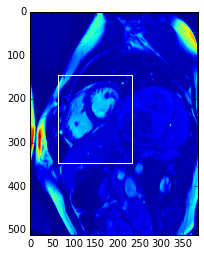

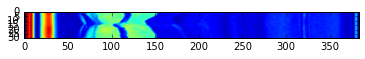

In [8]:
import sys
import os
import re
import dicom
import numpy as np
import matplotlib.pyplot as plt
import skimage.filters as filters
from scipy.fftpack import fftn, ifftn
#import skimage.feature as feature
#import skimage.transform as transform
#import scipy.ndimage as ndi

def getMaxAndMin(data):
    theMin=np.Inf
    theMinLoc=None
    theMax=-np.Inf
    theMaxLoc=None
    for i,d in enumerate(data):
        if d<theMin:
            theMin=d
            theMinLoc=i
        if d>theMax:
            theMax=d
            theMaxLoc=i
    return (theMin,theMinLoc),(theMax,theMaxLoc)
def roiAroundMax(data,factor,expansion_factor):
    (theMin,theMinLoc),(theMax,theMaxLoc)=getMaxAndMin(data)
    limit=theMax-(theMax-theMin)*factor
    low=theMaxLoc
    high=theMaxLoc
    while data[low]>limit and low>0:
        low-=1
    while data[high]>limit and high<len(data)-1:
        high+=1
    #plt.clf()
    #plt.plot(data)
    #plt.plot([low,low],[theMin,theMax])
    #plt.plot([high,high],[theMin,theMax])
    #plt.show()
    low=max(0,np.floor(low-(high-low)*expansion_factor))
    high=min(len(data-1),np.ceil(high+(high-low)*expansion_factor))
    return (int(low),int(high))
def heart_shaped_box(img,expansion_factor):
    Z=fftn(dset.images)
    Q=np.sum(np.abs(ifftn(Z[:,1,:,:].squeeze())),0)
    Qfilt=filters.gaussian(Q,10)
    axis1limits=roiAroundMax(np.sum(Qfilt,0),1./3.,0.0)
    axis0limits1=roiAroundMax(np.sum(Qfilt[:,axis1limits],1),1./2.,0.0)
    axis1limits1=roiAroundMax(np.sum(Qfilt[axis0limits1,:],0),1./2.,0.0)
    axis0limits=roiAroundMax(np.sum(Qfilt[:,axis1limits1],1),1./2.,expansion_factor)
    axis1limits=roiAroundMax(np.sum(Qfilt[axis0limits1,:],0),1./2.,expansion_factor)
    return (axis0limits[0],axis1limits[0]),(axis0limits[1],axis1limits[1]),



class Dataset(object):
    dataset_count = 0

    def __init__(self, directory, subdir):
        # deal with any intervening directories
        self.errors=[]
        while True:
            subdirs = next(os.walk(directory))[1]
            if len(subdirs) == 1:
                directory = os.path.join(directory, subdirs[0])
            else:
                break

        slices = []
        for s in subdirs:
            m = re.match("sax_(\d+)", s)
            if m is not None:
                slices.append(int(m.group(1)))
            else:
                print "skipping",s

        slices_map = {}
        first = True
        times = []
        for s in slices:
            print "Parsing",s
            files = next(os.walk(os.path.join(directory, "sax_%d" % s)))[2]
            offset = None
            thisTimes=[]

            for f in files:
                m = re.match("IM-(\d{4,})-(\d{4})\.dcm", f)
                if m is not None:
                    grp=int(m.group(1))
                    thisTimes.append(int(m.group(2)))
                    if offset is None:
                        offset = grp
                    elif grp != offset:
                        print "ERROR: In slice %d, found more than one group: %d %d"%(s,offset,grp)  
                        
                else:
                    print "----skipping",f
            if first:
                times=thisTimes[:]
                if set(times) != set(range(1,len(times)+1)):
                    print "ERROR: times not contiguous",times
            else:
                if set(times) != set(thisTimes):
                    print "ERROR: in slice %d, times are different"%s

            first = False
            slices_map[s] = offset

        self.directory = directory
        self.time = sorted(times)
        self.slices = sorted(slices)
        self.slices_map = slices_map
        Dataset.dataset_count += 1
        self.name = subdir
    def _filename(self, s, t):
        return os.path.join(self.directory,"sax_%d" % s, "IM-%04d-%04d.dcm" % (self.slices_map[s], t))

    def _read_dicom_image(self, filename):
        d = dicom.read_file(filename)
        img = d.pixel_array
        return np.array(img)
    def _read_coordinate_system(self, filename):
        r=itkReader.New()
        r.SetFileName(filename)
        r.Update()
        cs=dict()
        I=[0,1,2]
        org=r.GetOutput().GetOrigin()
        sp=r.GetOutput().GetSpacing()
        di=r.GetOutput().GetDirection()
        sz=r.GetOutput().GetLargestPossibleRegion().GetSize()
        cs["Origin"]=np.array([org[i] for i in I])
        cs["Spacing"]=np.array([sp[i] for i in I])
        cs["Direction"]=np.array([[di(i,j) for j in I] for i in I])
        cs["Size"]=np.array([sz[i] for i in I])
        return cs

    def _read_all_dicom_images(self):
        f1 = self._filename(self.slices[0], self.time[0])
        print "reading",f1
        d1 = dicom.read_file(f1)
        (x, y) = d1.PixelSpacing
        (x, y) = (float(x), float(y))
        f2 = self._filename(self.slices[1], self.time[0])
        d2 = dicom.read_file(f2)

        # try a couple of things to measure distance between slices
        try:
            dist = np.abs(d2.SliceLocation - d1.SliceLocation)
        except AttributeError:
            try:
                dist = d1.SliceThickness
            except AttributeError:
                dist = 8  # better than nothing...

        self.images = np.array([[self._read_dicom_image(self._filename(d, i))
                                 for i in self.time]
                                for d in self.slices])
        #self.coordinate_systems = [[self._read_coordinate_system(self._filename(d, i))
        #                            for i in self.time] for d in self.slices]
        #for d in range(self.images.shape[1]):                               
        #   for i in range(self.images.shape[0]):
        #       print "houghing it",d,i
        #       s,c=hough(self.images[i,d,:,:].copy())
        #       print len(s),len(c)
        #self.circles=[[hough(self.images[i,d,:,:].copy()) for i in range(self.images.shape[0])] for d in range(self.images.shape[1])]
        self.dicom=d2
        self.dist = dist
        self.area_multiplier = x * y
        self.pixel_spacing=(x,y,dist)
        self.box = heart_shaped_box(self.images,0.2)

    def load(self):
        self._read_all_dicom_images()
    def segment1(self):
        iteration=0
        for i in range(self.images.shape[0]):
            for j in range(self.images.shape[1]):
                iteration+=1
                img=self.images[i,j,:,:].squeeze().astype(np.float)
                img=img-np.min(img)
                img=img/np.max(img)*255
                lines=feature.canny(img,low_threshold=50,high_threshold=100)
                accum=transform.hough_circle(lines,np.array(range(10,50)),normalize=True)
                maxaccum=ndi.maximum_filter(accum,size=(2,5,5),mode='constant')
                peaks=np.logical_and(maxaccum==accum,maxaccum>0)
                peaksvals=maxaccum*(peaks)
                labeled_array,num_features=ndi.label(peaks,ndi.generate_binary_structure(3,2))
                com=ndi.measurements.center_of_mass(peaks,labeled_array,range(1,num_features+1))
                minima,maxima,minpos,maxpos=ndi.extrema(peaksvals,labeled_array,range(1,num_features+1))
                #plt.hist(peaksvals[peaks>0])
                sortedCircleIndices=sorted(range(len(maxima)),key=lambda x:-maxima[x])
                def makeCircle(i):
                    ctr=(com[i][2],com[i][1])
                    rad=com[i][0]+10
                    x=np.cos(np.linspace(-np.pi,np.pi,100))*rad+ctr[0]
                    y=np.sin(np.linspace(-np.pi,np.pi,100))*rad+ctr[1]
                    return x,y   
                plt.imshow(img)
                for i in sortedCircleIndices[:20]:
                    x,y=makeCircle(i)
                    plt.plot(x,y,'r-')
#                for c in circles:
#                    circ=plt.Circle((c[0],c[1]),c[2],color='r',fill=False)
#                    plt.gcf().gca().add_artist(circ)
                plt.show()
                break
            else:
                continue
            break


    def _makeRef(self):
        f=[slice(0,z,1) for z in self.images.shape]
        f[self.animationIndex]=self.frame
        f[self.planeIndex]=self.plane
        return tuple(f)
    def _onkey(self,event):
        if event.key == "up":
            self.animationIndex=(self.animationIndex+1)%4
            if self.animationIndex==self.planeIndex:
                self.animationIndex=(self.animationIndex+1)%4
            self.frame=self.plane%self.images.shape[self.animationIndex]
        elif event.key == "down":
            self.animationIndex=(self.animationIndex-1)%4
            if self.animationIndex==self.planeIndex:
               self.animationIndex=(self.animationIndex-1)%4
            self.frame=self.plane%self.images.shape[self.animationIndex]
        elif event.key == "left":
            self.planeIndex=(self.planeIndex+1)%4
            if self.animationIndex==self.planeIndex:
               self.planeIndex=(self.planeIndex+1)%4
            self.plane=self.plane%self.images.shape[self.planeIndex]
        elif event.key == "right":
            self.planeIndex=(self.planeIndex-1)%4
            if self.animationIndex==self.planeIndex:
               self.planeIndex=(self.planeIndex-1)%4
            self.plane=self.plane%self.images.shape[self.planeIndex]
        
    #'button=%d, x=%d, y=%d, xdata=%f, ydata=%f'%(
    #    event.button, event.x, event.y, event.xdata, event.ydata)
    def _onscroll(self,event):
        if event.button=='down':
            if self.plane > 0:
                self.plane-=1
        elif event.button=='up':
            if self.plane < self.images.shape[self.planeIndex]-1:
                self.plane+=1
        #'button=%d, x=%d, y=%d, xdata=%f, ydata=%f'%(
        #    event.button, event.x, event.y, event.xdata, event.ydata)
    def _initfig(self,*args):
        self.frame=0
        self.animationIndex=1
        self.planeIndex=0
        self.plane=self.images.shape[self.planeIndex]//2
        self.im = plt.imshow(self.images[self._makeRef()].squeeze(), cmap=plt.get_cmap('gray'), animated=True)
        xlimits=plt.xlim()
        ylimits=plt.ylim()
        self.title=plt.title("%s Plane %02d / %02d step %02d / %02d in %s"%
           (names[self.planeIndex],self.plane,self.images.shape[self.planeIndex],
            self.frame,self.images.shape[self.animationIndex],names[self.animationIndex]))
        (y1,x1),(y2,x2)=self.box
        self.roibox=plt.plot([x1,x1,x2,x2,x1],[y1,y2,y2,y1,y1],'w-')
        plt.xlim(xlimits)
        plt.ylim(ylimits)

        pass
    def _updatefig(self,*args):
        self.frame=(self.frame+1)%self.images.shape[self.animationIndex]
        self.im.set_array(self.images[self._makeRef()].squeeze())
        self.title.set_text("%s Plane %02d / %02d step %02d / %02d in %s" % 
           (names[self.planeIndex],self.plane,self.images.shape[self.planeIndex],
            self.frame,self.images.shape[self.animationIndex],names[self.animationIndex]))
        return self.im,self.title
    

    def show(self):
        try:
           if self.images.shape[1]<1:
               raise Exception("No images")
        except:
           print "No images to show (try loading...)"
           return
        fig = plt.figure()
        self.ani = animation.FuncAnimation(fig, self._updatefig, init_func=self._initfig, interval=50, blit=False, frames=self.images.shape[1])
        #self.ani.save('/storage/rupert/animheart.avi')
        cidscroll = fig.canvas.mpl_connect('scroll_event', self._onscroll)
        cidkey = fig.canvas.mpl_connect('key_release_event', self._onkey)
        plt.show()      
        
%matplotlib inline
dset=Dataset("/storage2/rupert/kaggleCardiac/train/264","264")
dset.load()

print dset.images.shape
print dset.pixel_spacing
print dset.time
plt.imshow(dset.images[5,15,:,:].squeeze())
xlimits=plt.xlim()
ylimits=plt.ylim()
#        self.title=plt.title("%s Plane %02d / %02d step %02d / %02d in %s"%
#           (names[self.planeIndex],self.plane,self.images.shape[self.planeIndex],
#            self.frame,self.images.shape[self.animationIndex],names[self.animationIndex]))
(y1,x1),(y2,x2)=dset.box
plt.plot([x1,x1,x2,x2,x1],[y1,y2,y2,y1,y1],'w-')
plt.xlim(xlimits)
plt.ylim(ylimits)

plt.show()
plt.imshow(dset.images[5,:,256,:].squeeze())
plt.show()

#dset.segment1()
#dset.show()     

(0.6484375, 0.6484375, 10.000000755508001)
(11, 168, 201)
Im here


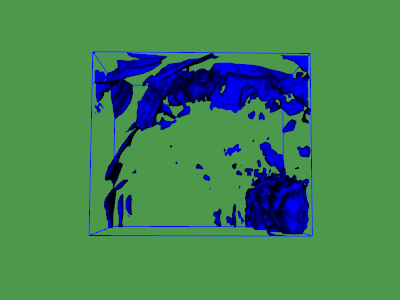

In [43]:
import vtk
from vtk.util.vtkConstants import *


from IPython.display import Image
def vtk_show(renderer, width=400, height=300):
    """
    Takes vtkRenderer instance and returns an IPython Image with the rendering.
    """
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(width, height)
    renderWindow.Render()
     
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()
     
    writer = vtk.vtkPNGWriter()
    writer.SetWriteToMemory(1)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    data = str(buffer(writer.GetResult()))
    
    return Image(data)

importer = vtk.vtkImageImport()
      
img_data = dset.images[:,15,x1:x2,y1:y2].squeeze().astype('uint16')

#img_data=np.zeros((128,128,128),dtype=np.uint8)
#img_data[10:110,10:100,10:100]=255
img_string = img_data.tostring()
dim = img_data.shape
        
importer.CopyImportVoidPointer(img_string, len(img_string))
importer.SetDataScalarType(VTK_UNSIGNED_SHORT)
importer.SetNumberOfScalarComponents(1)
        
extent = importer.GetDataExtent()
importer.SetDataExtent(extent[0], extent[0] + dim[2] - 1,
                       extent[2], extent[2] + dim[1] - 1,
                       extent[4], extent[4] + dim[0] - 1)
importer.SetWholeExtent(extent[0], extent[0] + dim[2] - 1,
                        extent[2], extent[2] + dim[1] - 1,
                        extent[4], extent[4] + dim[0] - 1)
importer.SetDataSpacing( dset.pixel_spacing[0], dset.pixel_spacing[1], dset.pixel_spacing[2])
print dset.pixel_spacing
print img_data.shape
    
outlineData=vtk.vtkOutlineFilter()
outlineData.SetInputConnection(importer.GetOutputPort())
    
mapOutline=vtk.vtkPolyDataMapper()
mapOutline.SetInputConnection(outlineData.GetOutputPort())
outline=vtk.vtkActor()
outline.SetMapper(mapOutline)
outline.GetProperty().SetColor(0,0,1)
outline.GetProperty().SetLineWidth(1.)
    
skinExtractor=vtk.vtkContourFilter()
skinExtractor.SetInputConnection(importer.GetOutputPort())
skinExtractor.SetValue(0,100)
skinExtractor.Update()
    
tri=vtk.vtkTriangleFilter()
tri.SetInputConnection(skinExtractor.GetOutputPort())
tri.Update()
    
#    deci=vtk.vtkQuadricDecimation()
#    deci.SetInputConnection(tri.GetOutputPort())
#    deci.SetTargetReduction(0.95)
#    # deci-$obj PreserveTopologyOn
#    deci.Update()
    
skinNormals=vtk.vtkPolyDataNormals()
    #  skinNormals SetInputConnection [skinExtractor GetOutputPort]
skinNormals.SetInputConnection(tri.GetOutputPort())
skinNormals.SetFeatureAngle( 60.0)
    
skinMapper=vtk.vtkPolyDataMapper()
skinMapper.SetInputConnection(skinNormals.GetOutputPort())
    #  skinMapper SetInputConnection [deci GetOutputPort]
#skinMapper.ScalarVisibilityOff()
       
skin=vtk.vtkActor()
skin.SetMapper(skinMapper)
skin.GetProperty().SetColor(1,0,0)


   
# skin.SetUserMatrix(M)
renderer=vtk.vtkRenderer()
renderer.AddActor(skin)
renderer.AddActor(outline)

renderer.SetBackground(.3, .6, .3)
 
renderWindow=vtk.vtkRenderWindow()
renderWindow.AddRenderer(renderer)
renderWindow.SetStereoTypeToRedBlue() #Anaglyphic FTW
 
renderWindowInteractor=vtk.vtkRenderWindowInteractor()
renderWindowInteractor.SetRenderWindow(renderWindow)
 
renderWindowInteractor.Start()

renderWindow.Finalize()
renderWindowInteractor.TerminateApp()
del renderWindow,renderWindowInteractor

print "Im here"
# this has to be the last thing
vtk_show(renderer)


In [31]:
dset.images.dtype


dtype('uint16')

In [28]:
VtkSourceSphere = vtk.vtkSphereSource()
VtkSourceSphere.SetCenter(0.0, 0.0, 0.0)
VtkSourceSphere.SetRadius(10.0)
VtkSourceSphere.SetPhiResolution(360)
VtkSourceSphere.SetThetaResolution(360)

VtkMapperSphere = vtk.vtkPolyDataMapper()
VtkMapperSphere.SetInputConnection(VtkSourceSphere.GetOutputPort())

VtkActorSphere = vtk.vtkActor()
VtkActorSphere.SetMapper(VtkMapperSphere)
VtkActorSphere.GetProperty().SetColor(1.0, 0.0, 0.0)

VtkRenderer = vtk.vtkRenderer()
VtkRenderer.SetBackground(1.0, 1.0, 1.0)
VtkRenderer.AddActor(VtkActorSphere)

vtk_show(VtkRenderer)
print "blah"

blah


Heart Dataset from 'Data Science Bowl Cardiac Challenge Data' https://www.kaggle.com/c/second-annual-data-science-bowl/data

Fonts from http://cm-unicode.sourceforge.net/
Styling based on https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers

In [1]:
from IPython.core.display import HTML


def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [ ]:
Resources
https://pyscience.wordpress.com/2014/09/03/ipython-notebook-vtk/